In [1]:
#导入相关库
try:
    import xml.etree.cElementTree as ET  #解析xml的c语言版的模块
except ImportError:
    import xml.etree.ElementTree as ET
import cv2
import numpy as np
import math
from scipy.spatial import Voronoi
from scipy.spatial import Delaunay
from scipy.spatial import voronoi_plot_2d
import matplotlib.pyplot as plt

In [2]:
#解析图片，获取图片标注位置
def GetAnnotBoxLoc(AnotPath):#AnotPath VOC标注文件路径
    tree = ET.ElementTree(file=AnotPath)  #打开文件，解析成一棵树型结构
    root = tree.getroot()#获取树型结构的根
    ObjectSet=root.findall('object')#找到文件中所有含有object关键字的地方，这些地方含有标注目标
    ObjBndBoxSet={} #以目标类别为关键字，目标框为值组成的字典结构
    for Object in ObjectSet:
        ObjName=Object.find('name').text
        BndBox=Object.find('bndbox')
        x1 = int(BndBox.find('xmin').text)#-1 #-1是因为程序是按0作为起始位置的
        y1 = int(BndBox.find('ymin').text)#-1
        x2 = int(BndBox.find('xmax').text)#-1
        y2 = int(BndBox.find('ymax').text)#-1
        BndBoxLoc=[x1,y1,x2,y2]
        if ObjName in ObjBndBoxSet:
            ObjBndBoxSet[ObjName].append(BndBoxLoc)#如果字典结构中含有这个类别了，那么这个目标框要追加到其值的末尾
        else:
            ObjBndBoxSet[ObjName]=[BndBoxLoc]#如果字典结构中没有这个类别，那么这个目标框就直接赋值给其值吧
    return ObjBndBoxSet
crossing = GetAnnotBoxLoc('C:/Users/lurchy/Desktop/EasyDL/8230-4502-0.5.xml')

In [3]:
#读取图片,计算矩形框中心坐标
img = cv2.imread('C:/Users/lurchy/Desktop/EasyDL/8230-4502-0.5.jpg')
cross = crossing['crossing']
#读取图片

spot_add = []
qian = []
m=0
for i in cross:
    qian.append(int((i[m]+i[m+2])/2))
    qian.append(int((i[m+1]+i[m+3])/2))
    spot_add.append(qian)
    qian = []

In [4]:
#图像显示函数
def cv_imshow(img,name):
    cv2.imshow(name,img)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [5]:
# def sobel_demo(image):
#     grad_x = cv2.Sobel(image, cv2.CV_32F, 1, 0)   #对x求一阶导
#     grad_y = cv2.Sobel(image, cv2.CV_32F, 0, 1)   #对y求一阶导
#     gradx = cv2.convertScaleAbs(grad_x)  #用convertScaleAbs()函数将其转回原来的uint8形式
#     grady = cv2.convertScaleAbs(grad_y)
# #     cv2.imshow("gradient_x", gradx)  #x方向上的梯度
# #     cv2.imshow("gradient_y", grady)  #y方向上的梯度
#     gradxy = cv2.addWeighted(gradx, 0.5, grady, 0.5, 0) #图片融合
#     cv2.imshow("gradient", gradxy)
# cv2.namedWindow('input_image', cv2.WINDOW_NORMAL) #设置为WINDOW_NORMAL可以任意缩放
# cv2.imshow('input_image', img)
# sobel_demo(img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [6]:
crossing

{'crossing': [[191, 243, 210, 262],
  [256, 273, 269, 285],
  [245, 312, 256, 324],
  [226, 330, 237, 343],
  [334, 320, 350, 331],
  [355, 361, 368, 373],
  [369, 283, 385, 298],
  [418, 326, 427, 337],
  [414, 358, 425, 368],
  [490, 278, 500, 289],
  [494, 292, 503, 301],
  [537, 320, 546, 328],
  [545, 233, 557, 246]]}

In [7]:
spot_add

[[200, 252],
 [262, 279],
 [250, 318],
 [231, 336],
 [342, 325],
 [361, 367],
 [377, 290],
 [422, 331],
 [419, 363],
 [495, 283],
 [498, 296],
 [541, 324],
 [551, 239]]

In [8]:
cv_imshow(img[330:343,226:237],'a')

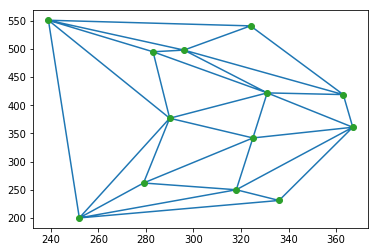

In [9]:
#使用Delaunay算法画边界
spot_add = np.array(spot_add)
points = spot_add
points[:,[0,1]]=points[:,[1,0]]
# vor  = Voronoi(points=points)
tri = Delaunay(points)
# voronoi_plot_2d(vor)
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0],points[:,1],'o')
plt.show()

In [ ]:
#去除多余的边界
#第一步:使用内外芯大边缘(外为0,内为1)与三角形面积做计算,计算重叠面积,去除线束外部多余边界
#第二步:使用双边滤波,再自动色阶,最后阈值取128,判断内部边界舍取
#Note:黑线必须在对角线上
edge = points[tri.simplices]#三角形点集合
#第一步
pass
#第二步
#双边滤波
d = cv2.getTrackbarPos("d","image")
sigmaColor = cv2.getTrackbarPos("sigmaColor","image")
sigmaSpace = cv2.getTrackbarPos("sigmaSpace","image")
img_ = cv2.bilateralFilter(img,d,sigmaColor,sigmaSpace)
# cv_imshow(img_,'a')
#自动色阶
def ComputeHist(img):
    h,w = img.shape
    hist, bin_edge = np.histogram(img.reshape(1,w*h), bins=list(range(257)))
    return hist
    
def ComputeMinLevel(hist, rate, pnum):
    sum = 0
    for i in range(256):
        sum += hist[i]
        if (sum >= (pnum * rate * 0.01)):
            return i
            
def ComputeMaxLevel(hist, rate, pnum):
    sum = 0
    for i in range(256):
        sum += hist[255-i]
        if (sum >= (pnum * rate * 0.01)):
            return 255-i
            
def LinearMap(minlevel, maxlevel):
    if (minlevel >= maxlevel):
        return []
    else:
        newmap = np.zeros(256)
        for i in range(256):    #获取阈值外的像素值 i< minlevel，i> maxlevel
            if (i < minlevel):
                newmap[i] = 0
            elif (i > maxlevel):
                newmap[i] = 255
            else:
                newmap[i] = (i-minlevel)/(maxlevel-minlevel) * 255
        return newmap
        
def CreateNewImg(img):
    h,w,d = img.shape
    newimg = np.zeros([h,w,d])
    for i in range(d):
        imgmin = np.min(img[:,:,i])
        imgmax = np.max(img[:,:,i])
        imghist = ComputeHist(img[:,:,i])
        minlevel = ComputeMinLevel(imghist, 8.3, h*w)
        maxlevel = ComputeMaxLevel(imghist, 2.2, h*w)
        newmap = LinearMap(minlevel,maxlevel)
        if (newmap.size ==0 ):
            continue
        for j in range(h):
            newimg[j,:,i] = newmap[img[j,:, i]]
    return newimg
newimg = CreateNewImg(img)
# cv_imshow(img,'c')
# cv_imshow(newimg,'a')
#截取图片算梯度
def grad_(m,n):#输入两个坐标，计算坐标之间梯度
    crop_img = img[m[1]:n[1],m[0]:n[0]]
    sobely = cv2.Sobel(crop_img,cv2.CV_64F,0,1,ksize=3)
    sobely = cv2.convertScaleAbs(sobely)
    s=0
    m=0
    for i in sobely:
        for j in i:
            for k in j:
                if k!=0:
                    m+=1
                    s+=k
    grad = s/m#梯度转化为与阈值判断的标准数据格式
    return grad
def ggb_c(m,n):#公共边选取
    ggb = []
    for i in m:
        for j in n:
            p = 0
            if(set(i)==set(j)):
                ggb.append(list(i))#公共边
    if(len(ggb)==2):
        print(ggb[0])
        if(grad_(ggb[0],ggb[1])>41.81):#计算梯度阈值
            k =1 #需要加入置1
        else:
            k=0
    ggb=[]
    return k
#选取需要去掉的边界
del_b = []#去边列表
for i in range(len(edge)):
    for j in range(len(edge)):
        if(i!=j):
#             compare_(edge[i],edge[j])
            k = ggb_c(edge[i],edge[j])
            if(k==1):
                gd=[]
                gd.append(edge[i])
                gd.append(edge[j])
                del_b.append(gd)#将该坐标对加入到去边列表中

[252, 200]
[290, 377]


In [ ]:
#画图，有一个坐标数组，默认里面都相连，有一个去边数组，里面是不需要连接的坐标对，怎样可视化出来
#使用白线覆盖掉
spot_add = np.array(spot_add)
points = spot_add
points[:,[0,1]]=points[:,[1,0]]
# vor  = Voronoi(points=points)
tri = Delaunay(points)
# voronoi_plot_2d(vor)
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0],points[:,1],'o')
for i in range(len(del_b)):
    for j in range(0,2):
        plt.plot(del_b[i][j][0],del_b[i][j][1],color = '#FFFFFF')